In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestRegressor
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import scipy

In [3]:
train = pd.read_csv(r'C:\Users\86151\Downloads\kaggle_credit_train_data.csv')

In [6]:
train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,1,0.287751,39,0,0.548950,6882.102709,9,0,1,0,1.715892
1,1,0,0.067156,59,0,0.377116,9744.000000,25,0,2,0,0.000000
2,2,0,0.030254,51,0,0.615891,3800.000000,16,0,2,0,0.000000
3,3,1,0.765109,53,1,0.551583,11000.000000,16,0,1,0,1.501489
4,4,0,0.025159,40,0,0.178416,13333.000000,6,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
195003,195003,0,0.000000,45,0,915.000000,0.110000,3,0,0,0,2.000000
195004,195004,1,0.542991,49,0,119.274808,0.437271,5,0,0,0,0.000000
195005,195005,0,0.004084,62,0,0.007328,1500.000000,6,0,0,0,0.000000
195006,195006,0,0.358643,31,0,0.607797,3000.000000,9,0,1,0,1.000000


In [9]:
train = train.iloc[:,1:]
train.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [28]:
def get_woe(num_bins):
        columns = ['min','max','ct_0','ct_1']
        df = pd.DataFrame(num_bins, columns = columns)
        df['total'] = df.ct_0 + df.ct_1
        df['perc'] = df.total/df.total.sum()
        df['bad_rate'] = df.ct_1/df.total
        df['good_p'] = df.ct_0/df.ct_0.sum()
        df['bad_p'] = df.ct_1/df.ct_1.sum()
        df['woe'] = np.log(df['good_p']/df['bad_p'])
        return df
    
def get_iv(df):
    rate = df.good_p - df.bad_p
    iv = np.sum(rate * df.woe)
    return iv

def graphforbestbin(DF,X,Y,n=5,q=20,graph=True):
    DF = DF[[X,Y]].copy()
    DF['qcut'], bins = pd.qcut(DF[X],retbins = True, q=q,duplicates = 'drop')
    ct_y0 = DF.loc[DF[Y] == 0].groupby(by = 'qcut').count()[Y]
    ct_y1 = DF.loc[DF[Y] == 1].groupby(by = 'qcut').count()[Y]
    num_bins = [*zip(bins,bins[1:],ct_y0,ct_y1)]
    
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(num_bins[0][0],num_bins[1][1],num_bins[0][2]+num_bins[1][2],num_bins[0][3]+num_bins[1][3])]
            continue
        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(num_bins[i-1][0],num_bins[i][1],num_bins[i-1][2]+num_bins[i][2],num_bins[i-1][3]+num_bins[i][3])]
            break
        else:
            break
    
    axisx = []
    iv = []
    
    print(len(num_bins))
    assert len(num_bins) > n
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)
        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(num_bins[i][0],num_bins[i+1][1],num_bins[i][2]+num_bins[i+1][2],num_bins[i][3]+num_bins[i+1][3])]

        bins_df0 = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        iv.append(get_iv(bins_df0))
        
    if graph:
        plt.figure()
        plt.plot(axisx,iv)
        plt.xticks(axisx)
        plt.show()
    return bins_df0

In [36]:
train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.287751,39,0,0.548950,6882.102709,9,0,1,0,1.715892
1,0,0.067156,59,0,0.377116,9744.000000,25,0,2,0,0.000000
2,0,0.030254,51,0,0.615891,3800.000000,16,0,2,0,0.000000
3,1,0.765109,53,1,0.551583,11000.000000,16,0,1,0,1.501489
4,0,0.025159,40,0,0.178416,13333.000000,6,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
195003,0,0.000000,45,0,915.000000,0.110000,3,0,0,0,2.000000
195004,1,0.542991,49,0,119.274808,0.437271,5,0,0,0,0.000000
195005,0,0.004084,62,0,0.007328,1500.000000,6,0,0,0,0.000000
195006,0,0.358643,31,0,0.607797,3000.000000,9,0,1,0,1.000000


RevolvingUtilizationOfUnsecuredLines
20


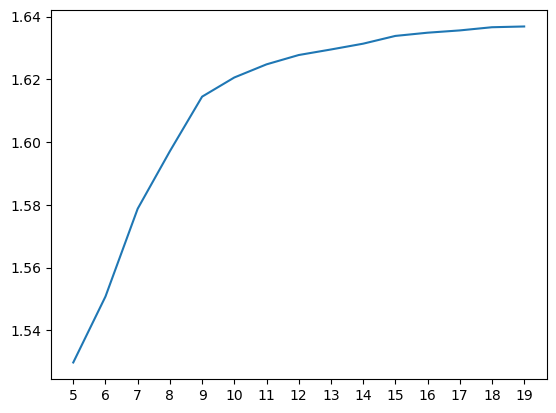

age
20


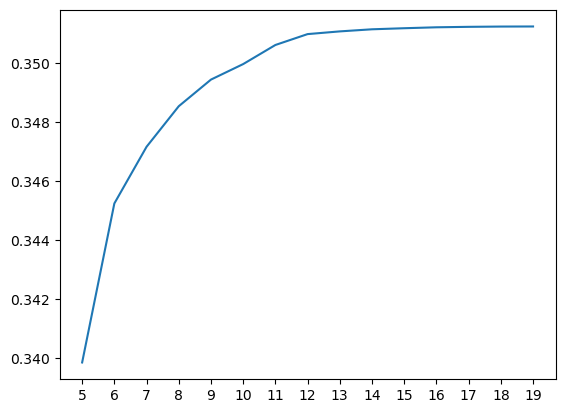

DebtRatio
20


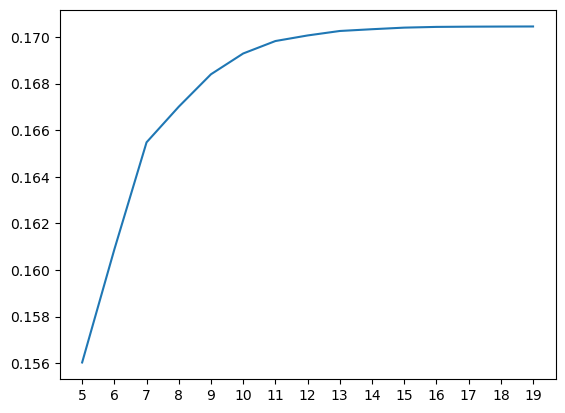

MonthlyIncome
20


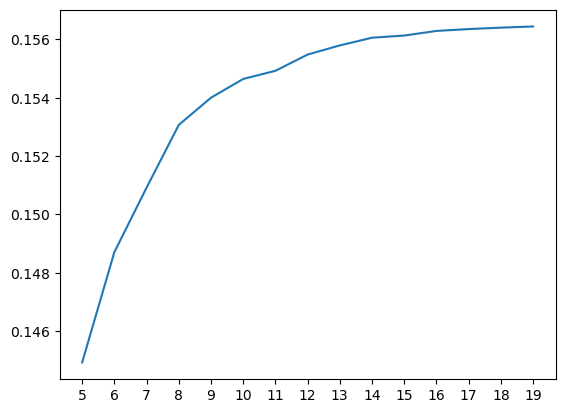

NumberOfOpenCreditLinesAndLoans
16


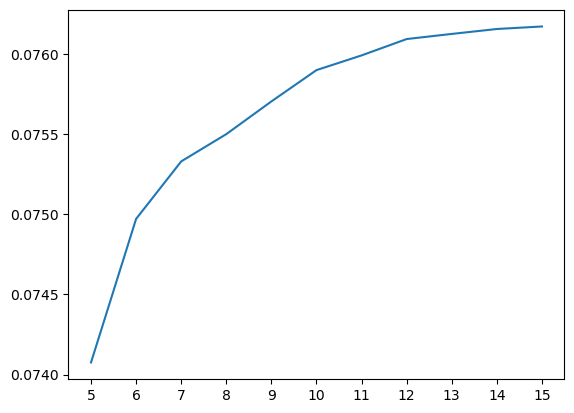

NumberOfDependents
9


ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

In [38]:
for i in ['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfDependents']:
    print(i)
    graphforbestbin(train,i,'SeriousDlqin2yrs',n=5,q=20,graph=True)